In [1]:
"""
Transform accumulated changes from fMRI layers into durations (s) using
multiclass SVM
"""

'\nTransform accumulated changes from fMRI layers into durations (s) using\nmulticlass SVM\n'

# IMPORT LIBS AND DATA 

In [19]:
from sklearn.svm import SVR
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy.io as sio
import scipy.stats as stats
import os.path as op
from sklearn.base import clone
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import chi2
# import pymc3 as pm
outdir = 'D:\\ERICK\\MD\\prediction_data\\'
datadir = 'D:\\ERICK\\MD\\'
load_file = op.join(datadir, 'master_dataset.csv')
data = pd.read_csv(load_file)

In [8]:
# plt.hist(data['gender'])

# NORMALIZED BIAS

In [100]:
#calculate bias
durations = [8, 12, 16, 20, 24]

dur_all = {'subj': [], 'duration': [], 'mean_report': [], 'bias_c': [], 'bias_off': [], 'bias':[], 'bias_mean':[]} 
error_all = {'subj': [], 'age': [], 'abs_error': [], 'bias': []}
corr_list = []
bias_diff = []
bias_off = []
bias_city = []
for subject in range(1, 41):
    size = data['subj'].value_counts()[subject]
    subset = data.loc[data['subj']==subject]
    subset = subset.reset_index(drop=True)
    
    error_all['subj'].append(subject) 
    error_all['age'].append(np.mean(subset['age']))
    error_all['abs_error'].append(np.mean(subset['estimationError'])) 
    error_all['bias'].append(np.mean(subset['humanBias'])) 
    
    subset_c = subset.loc[subset['isCity']==1]
    bias_city.append(np.mean(subset_c['humanBias']))
    subset_o = subset.loc[subset['isCity']==0]
    bias_off.append(np.mean(subset_o['humanBias']))
    diff = np.mean(subset_c['humanBias'])-np.mean(subset_o['humanBias'])
    bias_diff.append(diff)
    corr, _ = stats.spearmanr(subset['veridicalDuration'], subset['humanReport'])
    corr_list.append(corr)
    for dur in durations:
        dur_list = []
        for trial in range(len(subset['veridicalDuration'])):
            if subset['veridicalDuration'][trial]==dur:
                dur_list.append(subset['humanReport'][trial])
        mean_dur = np.mean(dur_list) 
        dur_all['subj'].append(subject)  
        dur_all['duration'].append(dur)   
        dur_all['mean_report'].append(mean_dur)
        subset_dur = subset.loc[subset['veridicalDuration']==dur]
        subset_c_dur = subset_c.loc[subset_c['veridicalDuration']==dur]
        subset_o_dur = subset_o.loc[subset_o['veridicalDuration']==dur]
        dur_all['bias_c'].append(subset_c_dur['humanBias'])
        dur_all['bias_off'].append(subset_o_dur['humanBias'])
        dur_all['bias'].append(subset_dur['humanBias'])
        dur_all['bias_mean'].append(np.mean(subset_dur['humanBias']))
dur_all = pd.DataFrame(dur_all)
sem = np.std(corr_list)/np.sqrt(len(corr_list))
print(f'Trial-by-trial correlation is: {np.mean(corr_list):.3f} +/- {sem:.3f}')

avgcorr_list = []
i = 0
for subj in range(1, 41):
    avg_corr, _ = stats.spearmanr(dur_all['duration'][i:i+5], dur_all['mean_report'][i:i+5])
    avgcorr_list.append(avg_corr)
    i = i + 5
sem = np.std(corr_list)/np.sqrt(len(avgcorr_list))
print(f'Average correlation whithin durations is: {np.mean(avgcorr_list):.3f} +/- {sem:.3f}')
    
bias_all = []
for row in range(len(data)):
    subj = data['subj'][row]
    dur = data['veridicalDuration'][row]
    subset = dur_all.loc[(dur_all['subj'] == subj) & (dur_all['duration'] == dur)]
    
    mr = subset['mean_report'].values[0]
    hr = data['humanReport'][row]
    bias = ((hr - mr)/mr)
    bias_all.append(bias)

print('-----------------------------------')
 
#calculate bias statistics
n = len(bias_diff)  # Tamanho da amostra
mean = np.mean(bias_diff)
SE = np.std(bias_diff, ddof=1)/np.sqrt(n)    
z = 1.96  # Valor crítico para um intervalo de confiança de 95%
lower_bound = mean - (z * SE)
upper_bound = mean + (z * SE)
t_statistic, p_value = stats.ttest_1samp(bias_diff, 0)
d = (mean - 0) / np.std(bias_diff, ddof=1)
print('Final statistics are M±SEdiff = {:.2f} ± {:.2f} (normalized bias, %), 95% CI [{:.2f}, {:.2f}], t39 = {:.2f}, p = {:.3f}, d = {:.2f}'
      .format(mean, SE, lower_bound, upper_bound, t_statistic, p_value, d))

Trial-by-trial correlation is: 0.763 +/- 0.016
Average correlation whithin durations is: 0.960 +/- 0.016
-----------------------------------
Final statistics are M±SEdiff = 5.23 ± 1.69 (normalized bias, %), 95% CI [1.92, 8.54], t39 = 3.09, p = 0.004, d = 0.49


Correlation: r = 0.09, p = 0.582
Linear Regression: beta = 0.00 ± 0.00, p = 0.407


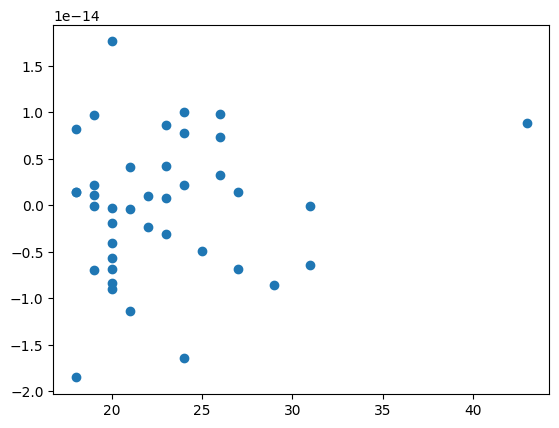

In [14]:
# Existe relação entre idade e erro de estimativa?
age = error_all['age']
error = error_all['bias']
plt.scatter(age, error)

#corr
rho,p = stats.spearmanr(age, error)
print('Correlation: r = {:.2f}, p = {:.3f}'.format(rho, p))
modelo = sm.OLS(error, sm.add_constant(age)).fit()
print('Linear Regression: beta = {:.2f} ± {:.2f}, p = {:.3f}'
      .format(modelo.params[1], modelo.bse[1], modelo.f_pvalue))

Text(0, 0.5, 'Viés de duração (recalculado)')

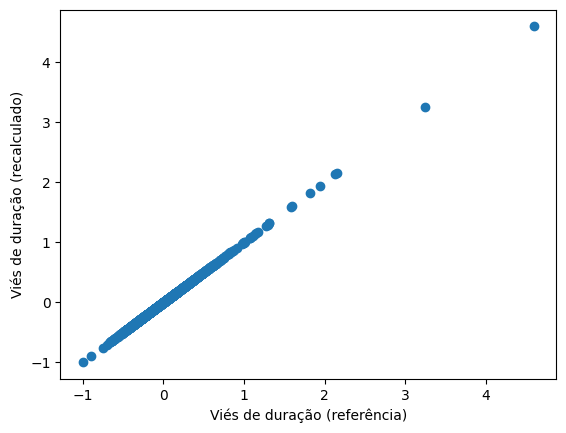

In [19]:
# plotando bias ground-truth com bias recalculado
plt.scatter(data['humanBias']/100, bias_all)
plt.xlabel('Viés de duração (referência)')
plt.ylabel('Viés de duração (recalculado)')

In [31]:
bias_diff = [x - y for x, y in zip(bias_city, bias_off)]
np.std(bias_diff, ddof=1)/np.sqrt(len(bias_diff))

1.6901084701417024

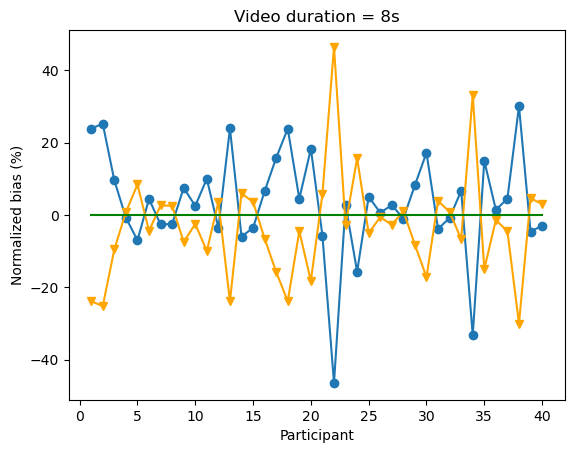

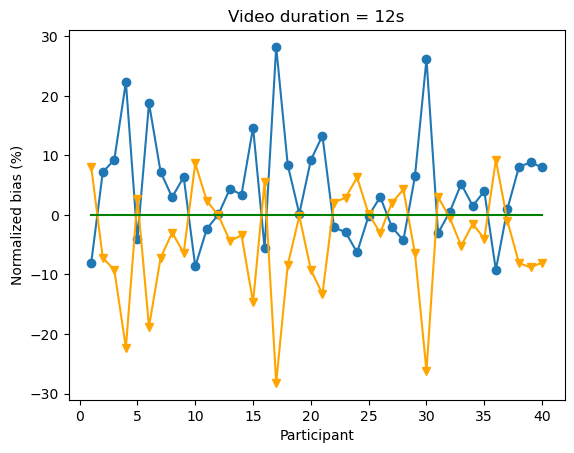

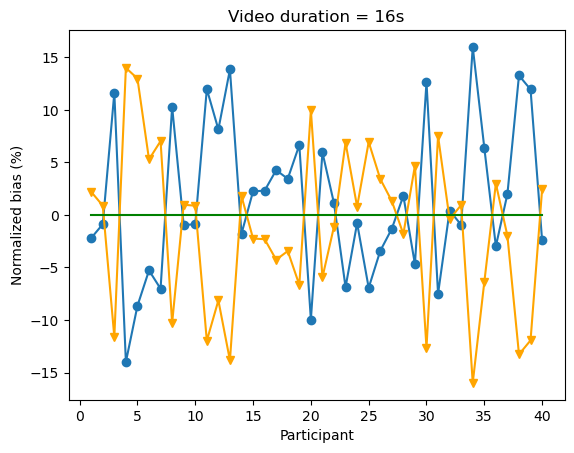

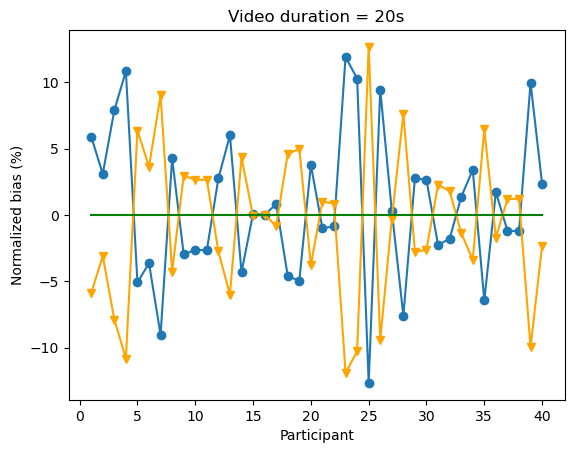

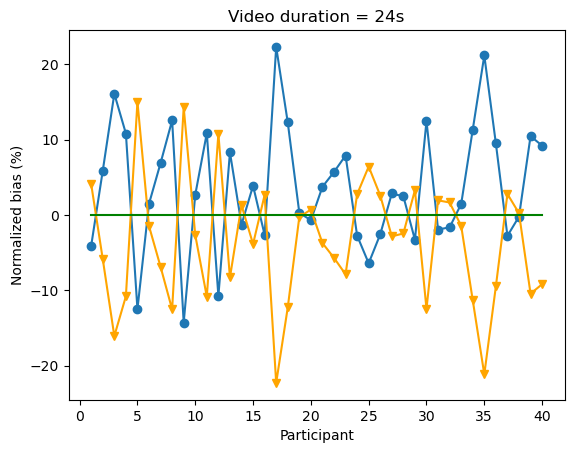

In [144]:
durations = [8, 12, 16, 20, 24]

# Calculando a média das séries para cada sujeito e duração
dur_all['bias_c_mean'] = dur_all['bias_c'].apply(lambda x: x.mean())
dur_all['bias_off_mean'] = dur_all['bias_off'].apply(lambda x: x.mean())
dur_all['bias_mean'] = dur_all['bias'].apply(lambda x: x.mean())

# # Agrupando por sujeito e duração para obter a média dos valores
# grouped = dur_all.groupby(['subj', 'duration'])

# Plotando o gráfico de bias por sujeito para cada duração
# durations = grouped['duration'].unique()

for duration in durations:
    plt.figure()
    subset = dur_all.loc[dur_all['duration'] == duration]
    
    # Plotar cada série com diferentes marcadores e linhas
    plt.plot(subset['subj'], subset['bias_c_mean'], marker='o', label='City')
    plt.plot(subset['subj'], subset['bias_off_mean'], marker='v',label='Off', color='orange')
    plt.plot(subset['subj'], subset['bias_mean'], label='Mean', color='green')
    
    plt.title(f'Video duration = {duration}s')
    plt.xlabel('Participant')
    plt.ylabel('Normalized bias (%)')
#     plt.legend('upper right')
#     plt.grid(True)
    plt.show()

# FIG 1

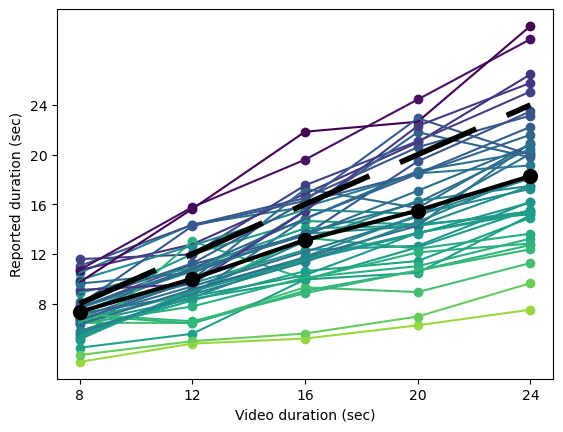

Average bias for city videos is: 2.627 +/- 0.831
Average bias for office videos is: -2.603 +/- 0.838


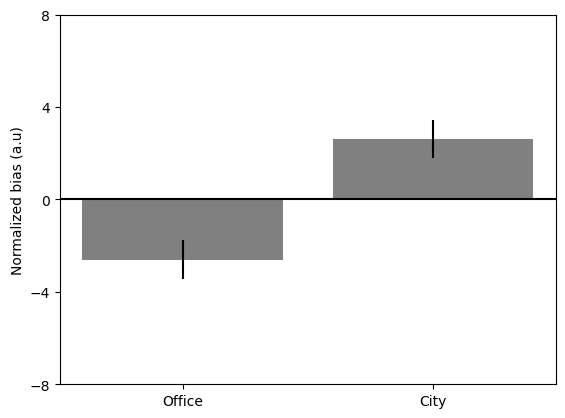

In [132]:
#fig1b
plt.figure()
i=0
vmin, vmax = np.max(dur_all['mean_report']), np.min(dur_all['mean_report'])
x = np.linspace(8, 24, 5)
y = x  # Função x=y
for subj in range(1, 41):
    dur = dur_all['duration'][i:i+5]
    mr = dur_all['mean_report'][i:i+5]
    cor = plt.cm.viridis((np.max(mr) - vmin) / (vmax - vmin))
    plt.plot(dur, mr, color=cor)
    plt.scatter(dur, mr, color=cor)
    i = i + 5

plt.xlabel('Video duration (sec)')
plt.ylabel('Reported duration (sec)')
plt.xticks(durations)
plt.yticks(durations)

#avg duration
avgdur = []
for dur in durations:
    subset = dur_all.loc[dur_all['duration']==dur]
    avgsub = np.mean(subset['mean_report'])
    avgdur.append(avgsub)
plt.plot(durations, avgdur, color='black', linewidth=3)
plt.scatter(durations, avgdur, color='black', linewidth=5, zorder=10)

#unity
plt.plot(x, y, color='black', linestyle='--', linewidth=4, dashes=[15,6])
# plt.title('FIG1B')
# plt.legend(['Curva 1', 'Curva 2', 'Curva 3', 'Curva 4'])
plt.show()

#fig1c
bias_c_dur = {}
bias_o_dur = {}
for dur in durations:
    i = 0
    bias_c_dur[dur]=[]
    bias_o_dur[dur]=[]
    for subject in range(1, 41):
        size = data['subj'].value_counts()[subject]
        subset = data.loc[i:i+size-1]
    #     print(subset['subj'])
        subcity = subset[(subset['isCity']==1) & (subset['veridicalDuration']==dur)]
        bias_c_dur[dur].append(np.mean(subcity['humanBias']))
        suboff = subset[(subset['isCity']==0) & (subset['veridicalDuration']==dur)]
        bias_o_dur[dur].append(np.mean(suboff['humanBias']))
#         bias_diff.append(bias_c[subject-1]-bias_o[subject-1])
#         bias_mean.append(np.mean(subset['humanBias']))
        i = i+size

i = 0
bias_c = []
bias_o = []
bias_mean = []
bias_diff = []
for subject in range(1, 41):
    size = data['subj'].value_counts()[subject]
    subset = data.loc[i:i+size-1]
#     print(subset['subj'])
    subcity = subset[subset['isCity']==1]
    bias_c.append(np.mean(subcity['humanBias']))
    suboff = subset[subset['isCity']==0]
    bias_o.append(np.mean(suboff['humanBias']))
    bias_diff.append(bias_c[subject-1]-bias_o[subject-1])
    bias_mean.append(np.mean(subset['humanBias']))
    i = i+size
    
std_c = np.std(bias_c)
sem_c = std_c / np.sqrt(len(bias_c))
print(f'Average bias for city videos is: {np.mean(bias_c):.3f} +/- {sem_c:.3f}')
std_o = np.std(bias_o)
sem_o = std_o / np.sqrt(len(bias_o))
print(f'Average bias for office videos is: {np.mean(bias_o):.3f} +/- {sem_o:.3f}')
    
plt.figure()
plt.bar('Office', np.mean(bias_o), yerr=sem_o, color='grey')
plt.bar('City', np.mean(bias_c), yerr=sem_c, color='grey')
plt.yticks([-8,-4,0,4,8])
plt.axhline(0, color='black')
plt.ylabel('Normalized bias (a.u)')
# plt.title('FIG1C')
plt.show()

Average bias for city videos is: 0.157 +/- 0.035
Average bias for office videos is: 0.200 +/- 0.032


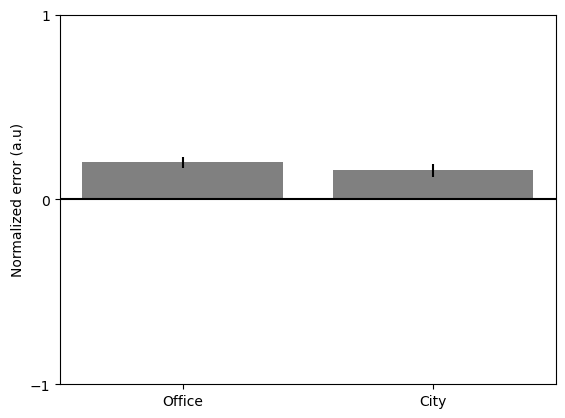

In [155]:
# normalized signed error
metric = 'signedError_norm' #this measure is calculated as: (report (trial) - veridicalDur)/veridicalDur

i = 0
error_c = []
error_o = []
# bias_mean = []
bias_diff = []
for subject in range(1, 41):
    size = data['subj'].value_counts()[subject]
    subset = data.loc[i:i+size-1]
#     print(subset['subj'])
    subcity = subset[subset['isCity']==1]
    error_c.append(np.mean(subcity[metric]))
    suboff = subset[subset['isCity']==0]
    error_o.append(np.mean(suboff[metric]))
#     bias_diff.append(bias_c[subject-1]-bias_o[subject-1])
#     bias_mean.append(np.mean(subset['humanBias']))
    i = i+size
    
std_c = np.std(error_c)
sem_c = std_c / np.sqrt(len(error_c))
print(f'Average bias for city videos is: {np.mean(error_c):.3f} +/- {sem_c:.3f}')
std_o = np.std(error_o)
sem_o = std_o / np.sqrt(len(error_o))
print(f'Average bias for office videos is: {np.mean(error_o):.3f} +/- {sem_o:.3f}')
    
plt.figure()
plt.bar('Office', np.mean(error_o), yerr=sem_o, color='grey')
plt.bar('City', np.mean(error_c), yerr=sem_c, color='grey')
plt.yticks([-1,0,1])
plt.axhline(0, color='black')
plt.ylabel('Normalized error (a.u)')
# plt.title('FIG1C')
plt.show()

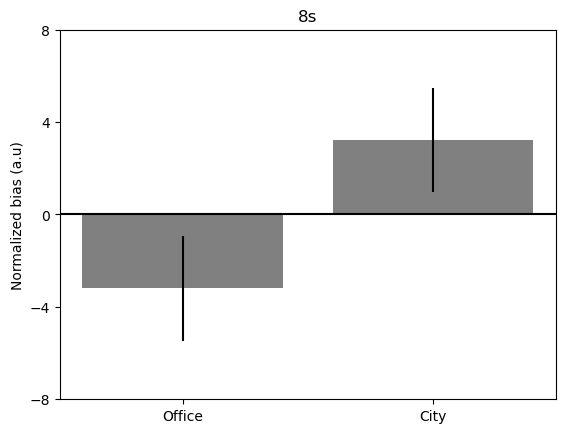

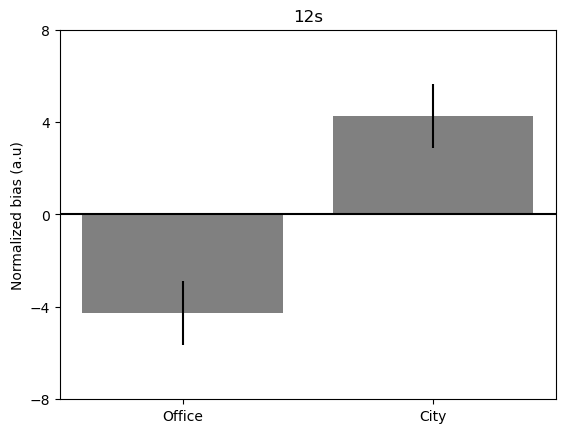

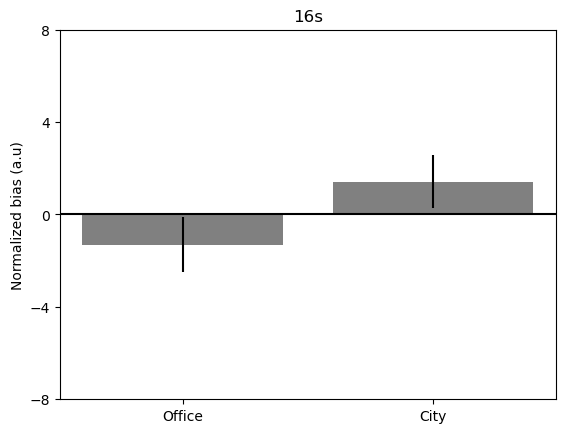

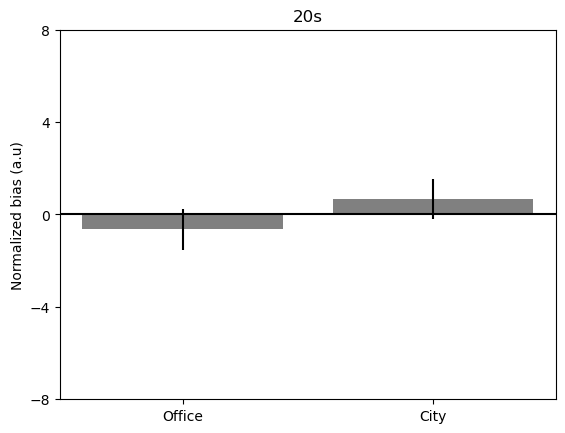

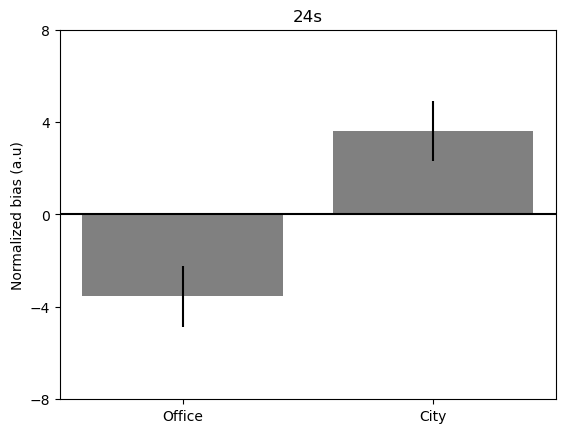

In [133]:
for dur in durations:
    std_c = np.std(bias_c_dur[dur])
    sem_c = std_c / np.sqrt(len(bias_c_dur[dur]))
    std_o = np.std(bias_o_dur[dur])
    sem_o = std_o / np.sqrt(len(bias_o_dur[dur]))
    
    plt.figure()
    plt.bar('Office', np.mean(bias_o_dur[dur]), yerr=sem_o, color='grey')
    plt.bar('City', np.mean(bias_c_dur[dur]), yerr=sem_c,color='grey')
    plt.yticks([-8,-4,0,4,8])
    plt.axhline(0, color='black')
    plt.ylabel('Normalized bias (a.u)')
    plt.title(f'{dur}s')
    plt.show()

In [131]:
bias_c_dur

{8: [-2.985074626865668],
 12: [8.00000000000002],
 16: [-2.4246877296105693],
 20: [2.3441966838193116],
 24: [9.198006343452635]}

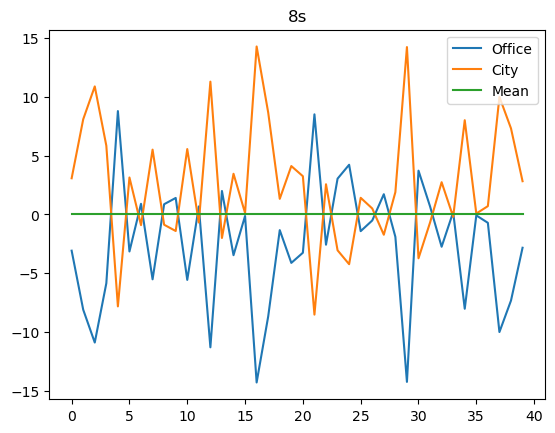

In [84]:
plt.plot(bias_o, label='Office')
plt.plot(bias_c, label='City')
plt.plot(bias_mean, label='Mean')
plt.legend(loc='upper right')
plt.title('8s')
plt.show()

In [62]:
np.array(bias_c)+np.array(bias_o)

array([-7.99360578e-15,  1.12105954e+01, -7.99360578e-15, -7.99360578e-15,
        8.60809660e+00])

# SVM

In [20]:
#create training data from salient events
resdir = 'D:\\ERICK\\MD\\Results\\'
origdir = 'D:\\ERICK\\MD\\predictions (ORIGINAL)\\'
regions = ['visual', 'auditory', 'somatosensory']
excluded = []
layers = [1, 2, 3]
df_visual, df_auditory, df_somatosensory = [],[],[] 

new_id = 1
for subject in range(4, 46):
    if subject in excluded:
        continue
#     print(subject)  
#     print(new_id)
    for region in regions:
#         print(region)
        data_layers = {'subj': [], 'duration': [], 'isCity': [], 'report': [], 'humanBias': [], 'estimationError': []}
        orig_file = op.join(origdir, 'predicted_{}.csv'.format(region))
        orig_data = pd.read_csv(orig_file, sep=',')
        for layer in layers:
            datafile = op.join(resdir, str(subject), 'accum_changes_{}_{}tmin=-1.mat'.format(region, layer))
            orig_layer = orig_data.loc[data['subj']==new_id, f'l{layer}']
            if op.isfile(datafile):
                df = sio.loadmat(datafile)
                df = df['d'][0][0]
                h = len(df[0])
                hb = data.loc[data['rawSubjID']==subject, 'humanBias']
                error = data.loc[data['rawSubjID']==subject, 'estimationError']
#                 print(subject, h, len(hb))
#                 print(data[0])
                if layer==1:
                    data_layers['subj'].extend([new_id] * h)
                    data_layers['duration'].extend(df[4].reshape(h))
                    data_layers['isCity'].extend(df[2].reshape(h))
                    data_layers['report'].extend(df[1].reshape(h))
                    data_layers['humanBias'].extend(hb)
                    data_layers['estimationError'].extend(error)
                data_layers['l{}'.format(layer)] = df[0].reshape(h)
                data_layers['l{}-orig'.format(layer)] = orig_layer.values
                data_layers['l{}-diff'.format(layer)] = df[0].reshape(h)-orig_layer.values
                    
        if region == 'visual':
            df_visual.append(pd.DataFrame(data_layers))
        elif region == 'auditory':
            df_auditory.append(pd.DataFrame(data_layers))
        else:
            df_somatosensory.append(pd.DataFrame(data_layers))
            
    if op.isfile(datafile):
        new_id = new_id + 1

df_visual = pd.concat(df_visual, ignore_index=True)
df_auditory = pd.concat(df_auditory, ignore_index=True)
df_somatosensory = pd.concat(df_somatosensory, ignore_index=True)

In [21]:
#save dataframes
for region in regions:
    save_path = op.join(outdir,'{}.csv'.format(region))
    if region=='visual':
        df_visual.to_csv(save_path, sep=',', encoding='utf-8')
    if region=='auditory':
        df_auditory.to_csv(save_path, sep=',', encoding='utf-8')
    if region=='somatosensory':
        df_somatosensory.to_csv(save_path, sep=',', encoding='utf-8')

In [22]:
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# outdir = 'D:\\ERICK\\MD\\predictions (ORIGINAL)\\'
files = ["visual", "auditory","somatosensory"]
target = 'duration'

for region in files:
    print(region)
    load_file = op.join(outdir, '{}.csv'.format(region))
    save_file = op.join(outdir, 'predicted_{}.csv'.format(region))
    data = pd.read_csv(load_file, sep=',')
    accumulated_changes = np.array(pd.concat([data.l1 , data.l2, data.l3],axis=1))
#     print(accumulated_changes)
    
    if target == 'videoType':
        regressor = LogisticRegression(max_iter=1000)
        out = np.array(data.isCity)
    else:
        out=np.array(data[target])
        # define model
        regressor = SVR(kernel='rbf', C=1e3, gamma=0.0001)
    #     regressor = ElasticNetCV(l1_ratio=0.5, n_alphas=20, random_state=42)
        
    regressor.fit(accumulated_changes, out)
    predicted = regressor.predict(accumulated_changes)
    output    = np.array(pd.concat([data.subj,data.duration,data.isCity,data.report, data.humanBias, data.estimationError,
                                    pd.Series(predicted), data.l1,data.l2,data.l3],axis=1))
    output = pd.DataFrame(output, columns=['subj', 'duration', 'isCity', 'report', 'humanBias', 'estimationError', 
                                           'predicted','l1', 'l2', 'l3'])
#     output.to_csv(save_file, sep=',', encoding='utf-8')
    
    # 10-fold cross val
    j = 0
    kf = KFold(n_splits=10, shuffle=True)
    rmse, rho, p, R2 = np.zeros(10), np.zeros(10), np.zeros(10), np.zeros(10)
    accuracy = np.zeros(10)

    for train_index, test_index in kf.split(accumulated_changes):
        X_train, X_test = accumulated_changes[train_index], accumulated_changes[test_index]
        Y_train, Y_test = out[train_index], out[test_index]
        
        if target == 'videoType':
            regressor.fit(X_train, Y_train)
            preds = regressor.predict_proba(X_test)[:, 1]
            accuracy[j] = accuracy_score(Y_test, preds > 0.5)
            j += 1
        else:    
            regressor.fit(X_train, Y_train)
            preds = regressor.predict(X_test)

            rho[j], p[j] = stats.pearsonr(np.ravel(preds), np.ravel(Y_test))
            R2[j] = 1 - np.sum(np.square(Y_test-preds)) / np.sum(np.square(Y_test-np.mean(Y_test)))
            rmse[j] = sqrt(mean_squared_error(Y_test, preds))
            j += 1
    if target == 'videoType':
        print("Acurácia:", np.mean(accuracy))
    else:
        print(f'r = {np.mean(rho[rho != 0]):.3f}, p = {np.mean(p[p != 0]):.3f}')
        print(f'R2 = {np.mean(R2[R2 != 0]):.3f}')
        print(f'RMSE is: {np.mean(rmse[rmse != 0]):.3f}')
    
#     # leave-one-subject-out
#     j = 0
#     rmse, rho, p, R2 = np.zeros(38), np.zeros(38), np.zeros(38), np.zeros(38)
#     data['index'] = np.arange(len(data))
#     subj_list = np.arange(1, 39)
    
#     for fold, subj in enumerate(subj_list):
#         print(f'Training fold {fold}, includes all subjects but {subj}')
#         train_ids = np.ravel(data.loc[~(data['subj'] == float(subj)), 'index'])
#         test_ids = np.ravel(data.loc[(data['subj'] == float(subj)), 'index'])
        
#         X_train, X_test = accumulated_changes[train_ids], accumulated_changes[test_ids]
#         Y_train, Y_test = out[train_ids], out[test_ids]

#         regressor.fit(X_train, Y_train)
#         preds = regressor.predict(X_test)

#         rho[j], p[j] = stats.pearsonr(np.ravel(preds), np.ravel(Y_test))
#         R2[j] = 1 - np.sum(np.square(Y_test-preds)) / np.sum(np.square(Y_test-np.mean(Y_test)))
#         rmse[j] = sqrt(mean_squared_error(Y_test, preds))
#         j += 1
#     print(f'r = {np.mean(rho[rho != 0]):.3f}, p = {np.mean(p[p != 0]):.3f}')
#     print(f'R2 = {np.mean(R2[R2 != 0]):.3f}')
#     print(f'RMSE is: {np.mean(rmse[rmse != 0]):.3f}')

visual
r = 0.966, p = 0.000
R2 = 0.932
RMSE is: 1.466
auditory
r = 0.981, p = 0.000
R2 = 0.962
RMSE is: 1.098
somatosensory
r = 0.977, p = 0.000
R2 = 0.954
RMSE is: 1.212


In [74]:
# testing SVR model for each layer, separately
# outdir = 'D:\\ERICK\\MD\\predictions (ORIGINAL)\\'
files = ["visual", "auditory","somatosensory"]
layers = ['l1', 'l2', 'l3']

columns = ['Região', 'Camada', 'r (Pearson)', 'p-value']
df = pd.DataFrame(columns=columns)

for region in files:
    print(region)
    load_file = op.join(outdir, 'predicted_{}.csv'.format(region))
    data = pd.read_csv(load_file, sep=',')
    for layer, l in enumerate(layers):
        save_file = op.join(outdir, 'predicted_{}_{}.csv'.format(region, l))
        print(l)
        accumulated_changes = np.array(data[l]).reshape(-1, 1)
    #     print(accumulated_changes)
        duration=np.array(data.duration)
        regressor = SVR(kernel='rbf', C=1e3, gamma=0.0001)
        regressor.fit(accumulated_changes, duration)
        predicted = regressor.predict(accumulated_changes)
        output    = np.array(pd.concat([data.subj,data.duration,data.isCity,data.report,
                                        pd.Series(predicted), data.l1,data.l2,data.l3],axis=1))
        output = pd.DataFrame(output, columns=['subj', 'duration', 'isCity', 'report', 'predicted', 'l1', 'l2', 'l3'])
        output.to_csv(save_file, sep=',', encoding='utf-8')

        # 10-fold cross val
        j = 0
        kf = KFold(n_splits=10, shuffle=True)
        rmse, rho, p = np.zeros(10), np.zeros(10), np.zeros(10)

        for train_index, test_index in kf.split(accumulated_changes):
            X_train, X_test = accumulated_changes[train_index], accumulated_changes[test_index]
            Y_train, Y_test = duration[train_index], duration[test_index]

            regressor.fit(X_train, Y_train)
            preds = regressor.predict(X_test)

            rho[j], p[j] = stats.pearsonr(np.ravel(preds), np.ravel(Y_test))
            rmse[j] = sqrt(mean_squared_error(Y_test, preds))
            j += 1
            
        mean_rho = np.round(np.mean(rho[rho != 0]), 2)
        mean_p = np.round(np.mean(p[p != 0]), 2)
        linha = [region, layer+1, mean_rho, mean_p]
        df.loc[len(df)] = linha
            
        print(f'r = {np.mean(rho[rho != 0]):.3f}, p = {np.mean(p[p != 0]):.3f}')
        print(f'RMSE is: {np.mean(rmse[rmse != 0]):.3f}')
        
outFile = op.join(outdir, 'svr_table_layers.csv')
df.to_csv(outFile, sep=',', encoding='utf-8')

visual
l1
r = 0.942, p = 0.000
RMSE is: 1.898
l2
r = 0.907, p = 0.000
RMSE is: 2.381
l3
r = 0.373, p = 0.000
RMSE is: 5.298
auditory
l1
r = 0.958, p = 0.000
RMSE is: 1.618
l2
r = 0.929, p = 0.000
RMSE is: 2.105
l3
r = 0.490, p = 0.000
RMSE is: 4.950
somatosensory
l1
r = 0.957, p = 0.000
RMSE is: 1.644
l2
r = 0.926, p = 0.000
RMSE is: 2.150
l3
r = 0.453, p = 0.000
RMSE is: 5.090


In [65]:
df

,Região,Camada,r (Pearson),p-value
0,visual,1,0.94,0.0
1,visual,2,0.91,0.0
2,visual,3,0.37,0.0
3,auditory,1,0.96,0.0
4,auditory,2,0.93,0.0
5,auditory,3,0.49,0.0
6,somatosensory,1,0.96,0.0
7,somatosensory,2,0.93,0.0
8,somatosensory,3,0.46,0.0


# FIG 5

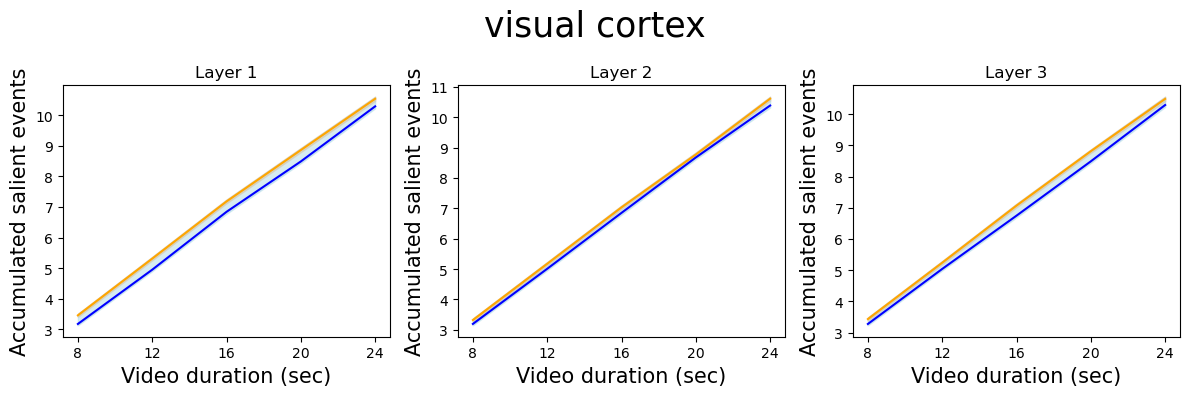

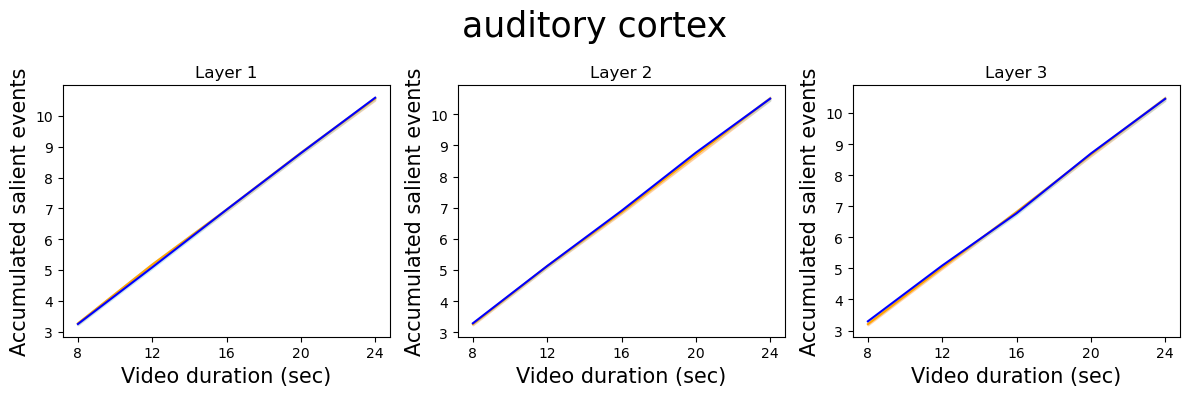

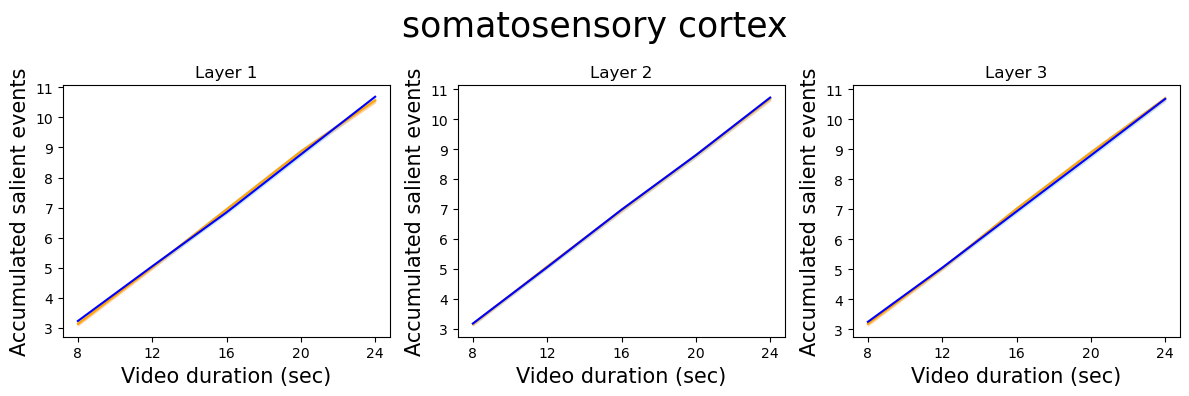

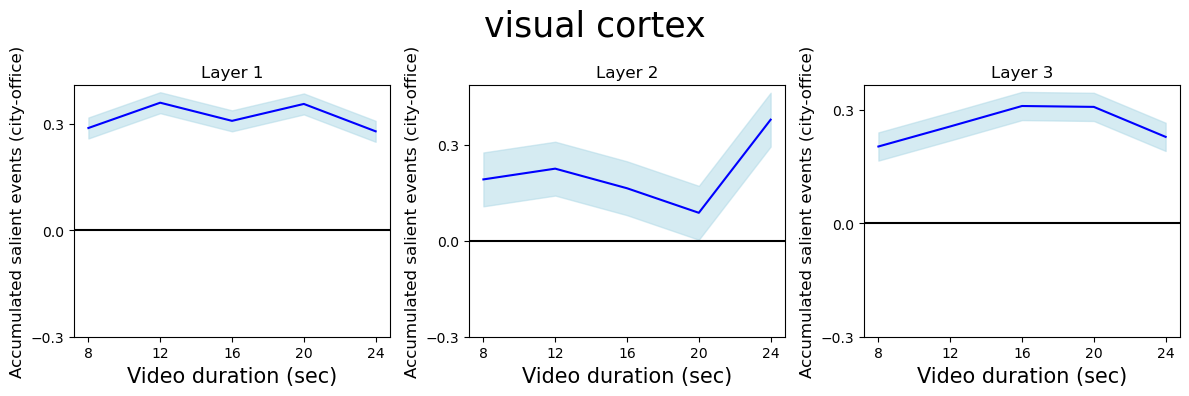

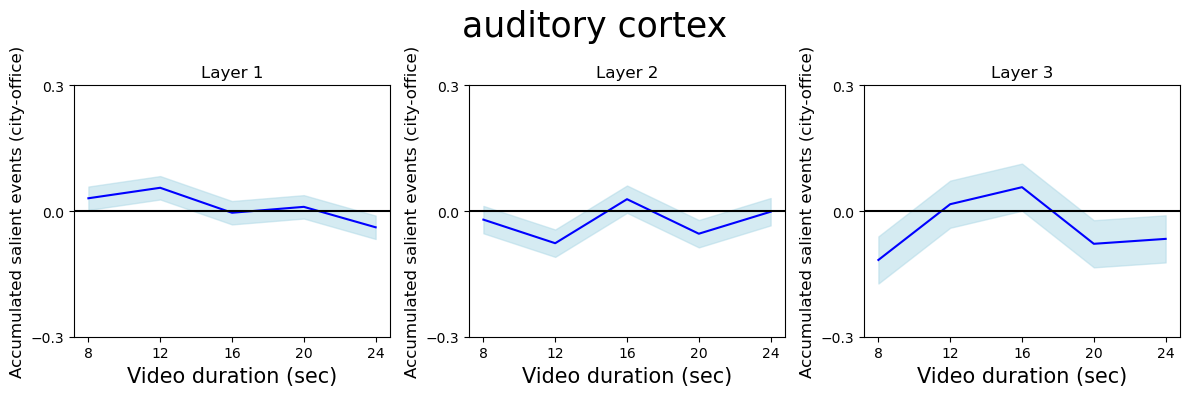

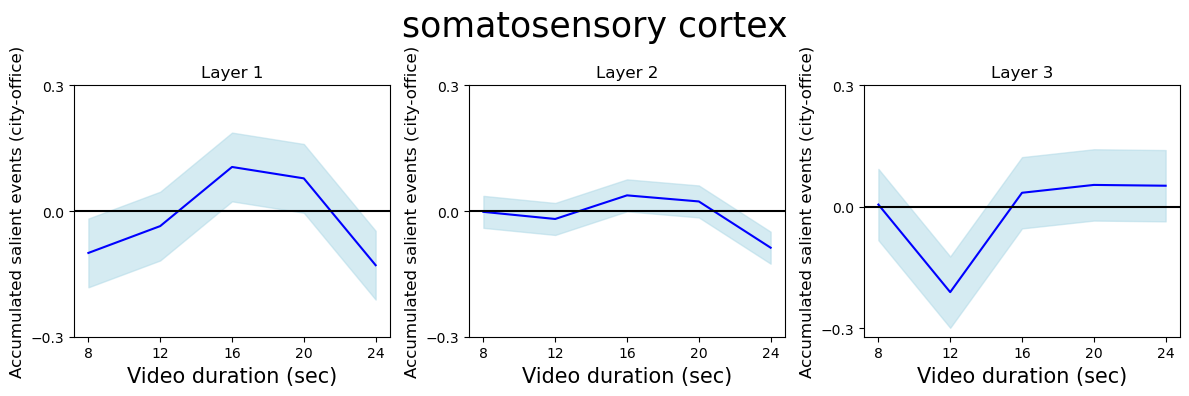

In [169]:
# outdir = 'D:\\ERICK\\MD\\predictions (ORIGINAL)\\'
outdir = 'D:\\ERICK\\MD\\prediction_data\\'
#plotting fig5 
#left
files = ["visual","auditory","somatosensory"]
layers = ['l1', 'l2', 'l3']
durations = [8, 12, 16, 20, 24]

i = 0
for region in files:
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    j = 0 
    for layer in layers:
        load_file = op.join(outdir, '{}_tmin=-1.csv'.format(region))
#         if region=='visual':
#             data = pd.read_csv(load_file, sep=';')
#         else:
        data = pd.read_csv(load_file)
        subcity = data[data['isCity']==1]
        suboff = data[data['isCity']==0]
        SE_city = subcity.groupby('duration')[layer].mean().tolist()
        sem_c = subcity.groupby('duration')[layer].sem().tolist()
#         sem_c = np.std(SE_city) / np.sqrt(len(SE_city))
        SE_off = suboff.groupby('duration')[layer].mean().tolist()
        sem_o = suboff.groupby('duration')[layer].sem().tolist()
#         sem_o = np.std(SE_off) / np.sqrt(len(SE_off))
        chart = axs[j]
        chart.plot(durations, SE_city, color='orange')
        chart.plot(durations, SE_off, color='blue')
        
        #plot SEM
        lbound_c = [a - b for a, b in zip(SE_city, sem_c)]
        ubound_c = [a + b for a, b in zip(SE_city, sem_c)]
        lbound_o = [a - b for a, b in zip(SE_off, sem_o)]
        ubound_o = [a + b for a, b in zip(SE_city, sem_c)]
        custom_color = (1.0, 0.7, 0.4)
        chart.fill_between(durations, lbound_c, ubound_c, color=custom_color, alpha=0.5)
        chart.fill_between(durations, lbound_o, ubound_o, color='lightblue', alpha=0.5)
        
        chart.set_title(f'Layer {j+1}')
        chart.set_xlabel('Video duration (sec)', fontsize=15)
        chart.set_ylabel('Accumulated salient events', fontsize=15) 
        chart.set_xticks(durations)
        j = j + 1
    fig.suptitle(f'{region} cortex', fontsize=25) 
    plt.tight_layout()
    i = i + 1
    
#right
i = 0
for region in files:
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    j = 0 
    for layer in layers:
        load_file = op.join(outdir, 'predicted_{}.csv'.format(region))
#         if region=='visual':
#             data = pd.read_csv(load_file, sep=';')
#         else:
        data = pd.read_csv(load_file)
        subcity = data[data['isCity']==1]
        suboff = data[data['isCity']==0]
        SE_city = subcity.groupby('duration')[layer].mean().tolist()
        SE_off = suboff.groupby('duration')[layer].mean().tolist()
        diff = np.array(SE_city)-np.array(SE_off)
        chart = axs[j]
        chart.plot(durations, diff, color='blue')
        chart.set_title(f'Layer {j+1}')
        chart.set_xlabel('Video duration (sec)', fontsize=15)
        chart.set_ylabel('Accumulated salient events (city-office)', fontsize=12) 
        chart.set_xticks(durations)
        chart.axhline(0, color='black')
        
        # Cálculo dos limites do intervalo de confiança
        n = len(diff)  # Tamanho da amostra
        z = 1.96  # Valor crítico para um intervalo de confiança de 95%
        lower_bound = diff - (z * np.std(diff) / np.sqrt(n))
        upper_bound = diff + (z * np.std(diff)  / np.sqrt(n))
        # Preenchimento do intervalo de confiança
        chart.fill_between(durations, lower_bound, upper_bound, color='lightblue', alpha=0.5)
        chart.set_yticks([-0.3, 0, 0.3])

        j = j + 1
        
    fig.suptitle(f'{region} cortex', fontsize=25) 
    plt.tight_layout()
    i = i + 1

In [159]:
sem_c

[0.05171466032499971,
 0.05822885577846806,
 0.06026083057276929,
 0.06697193893329269,
 0.06896360577377558]

In [26]:
data

,Unnamed: 0,subj,duration,isCity,report,humanBias,estimationError,predicted,l1,l2,l3
0,0,1.0,24.0,0.0,29.5,97.654941,5.5,22.275896,10.0,8.0,2.0
1,1,1.0,16.0,1.0,14.7,38.461538,1.3,14.512073,6.0,6.0,1.0
2,2,1.0,20.0,0.0,18.4,61.050328,1.6,18.087614,8.0,6.0,2.0
3,3,1.0,8.0,1.0,9.8,72.941176,1.8,7.999015,3.0,2.0,0.0
4,4,1.0,8.0,0.0,3.1,-45.294118,4.9,7.898483,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2326,2326,40.0,24.0,1.0,21.5,16.900770,2.5,20.185125,9.0,7.0,2.0
2327,2327,40.0,24.0,0.0,20.9,13.638423,3.1,23.721775,11.0,8.0,4.0
2328,2328,40.0,20.0,1.0,14.4,-1.200686,5.6,21.837695,10.0,7.0,3.0
2329,2329,40.0,12.0,0.0,8.1,-7.428571,3.9,11.785403,5.0,3.0,2.0


# MODEL BIAS

In [23]:
#calculate model bias for each subject
files = ["visual","auditory","somatosensory"]
overwrite=True
durations = [8, 12, 16, 20, 24]
dur_dic = {8:0, 12:1, 16:2, 20:3, 24:4}
modelBias_off = {'visual':[], 'auditory':[], 'somatosensory':[]}
modelBias_city = {'visual':[], 'auditory':[], 'somatosensory':[]}
avgmb_diff = {'visual':[], 'auditory':[], 'somatosensory':[]}
modelBias_all = {'visual':[], 'auditory':[], 'somatosensory':[]}
avgmb_all = {'visual':[], 'auditory':[], 'somatosensory':[]}
avgmb_c = {'visual':[], 'auditory':[], 'somatosensory':[]}
avgmb_o = {'visual':[], 'auditory':[], 'somatosensory':[]}
# outdir = 'D:\\ERICK\\MD\\predictions (ORIGINAL)\\'

for region in files:
    print(region)
    load_file = op.join(outdir, 'predicted_{}.csv'.format(region))
    data = pd.read_csv(load_file)
    for subj in range(1, 39): # mudar caso mude o tamanho da amostra
        subset_c = data.loc[(data['subj'] == subj) & (data['isCity'] == 1)]
        subset_o = data.loc[(data['subj'] == subj) & (data['isCity'] == 0)]
        subset = data.loc[(data['subj'] == subj)]
        mb_subcity = []
        mb_suboff = []
        mb_suball = []
    
        for dur in durations:
            mean_dur = subset.groupby('duration')['predicted'].mean().tolist() 
        for ind, row in subset.iterrows():
            modelrep = row['predicted']
            md_idx = dur_dic[row['duration']]
            model_bias = 100*(modelrep-mean_dur[md_idx])/mean_dur[md_idx]
            mb_suball.append(model_bias)
            modelBias_all[region].append(model_bias)
        for ind, row in subset_c.iterrows():
            modelrep = row['predicted']
#             print('predicted is', modelrep)
            md_idx = dur_dic[row['duration']]
#             print('mean dur is', mean_dur_c[md_idx])
            model_bias = 100*(modelrep-mean_dur[md_idx])/mean_dur[md_idx]
#             print('model bias is', model_bias)
            mb_subcity.append(model_bias)
            modelBias_city[region].append(model_bias)
        for ind, row in subset_o.iterrows():
            modelrep = row['predicted']
            md_idx = dur_dic[row['duration']]
            model_bias = 100*(modelrep-mean_dur[md_idx])/mean_dur[md_idx]
            mb_suboff.append(model_bias)
            modelBias_off[region].append(model_bias)
        #calculate diff
        diff = np.mean(mb_subcity)-np.mean(mb_suboff)
#         print(diff)
        avgmb_diff[region].append(diff)
        #average within subject
        avgmb_c[region].append(np.mean(mb_subcity))
        avgmb_o[region].append(np.mean(mb_suboff))
        avgmb_all[region].append(np.mean(mb_suball))
        
    #overwrite file
    if overwrite:
        data['modelBias'] = modelBias_all[region]
        data.to_csv(load_file, sep=',', encoding='utf-8')

visual
auditory
somatosensory


In [147]:
# PARA CADA CAMADA
#calculate model bias for each subject
overwrite=False
files = ["visual","auditory","somatosensory"]
durations = [8, 12, 16, 20, 24]
dur_dic = {8:0, 12:1, 16:2, 20:3, 24:4}
ref_dic = {'visual_l1':[], 'auditory_l1':[], 'somatosensory_l1':[], 'visual_l2':[], 'auditory_l2':[], 
                 'somatosensory_l2':[], 'visual_l3':[], 'auditory_l3':[], 'somatosensory_l3':[]}
modelBias_off = ref_dic
modelBias_city = ref_dic
avgmb_diff = ref_dic
modelBias_all = {'visual_l1':[], 'auditory_l1':[], 'somatosensory_l1':[], 'visual_l2':[], 'auditory_l2':[], 
                 'somatosensory_l2':[], 'visual_l3':[], 'auditory_l3':[], 'somatosensory_l3':[]}
avgmb_all = ref_dic
avgmb_c = ref_dic
avgmb_o = ref_dic
# outdir = 'D:\\ERICK\\MD\\predictions (ORIGINAL)\\'

for region in files:
    print(region)
    for layer, l in enumerate(layers):
        print(l)
        load_file = op.join(outdir, 'predicted_{}_{}.csv'.format(region, l))
        data = pd.read_csv(load_file)
        for subj in range(1, 39): # mudar caso mude o tamanho da amostra
            subset_c = data.loc[(data['subj'] == subj) & (data['isCity'] == 1)]
            subset_o = data.loc[(data['subj'] == subj) & (data['isCity'] == 0)]
            subset = data.loc[(data['subj'] == subj)]
            mb_subcity = []
            mb_suboff = []
            mb_suball = []

            for dur in durations:
                mean_dur = subset.groupby('duration')['predicted'].mean().tolist() 
            for ind, row in subset.iterrows():
                modelrep = row['predicted']
                md_idx = dur_dic[row['duration']]
                model_bias = 100*(modelrep-mean_dur[md_idx])/mean_dur[md_idx]
                mb_suball.append(model_bias)
                modelBias_all[f'{region}_{l}'].append(model_bias)
            for ind, row in subset_c.iterrows():
                modelrep = row['predicted']
    #             print('predicted is', modelrep)
                md_idx = dur_dic[row['duration']]
    #             print('mean dur is', mean_dur_c[md_idx])
                model_bias = 100*(modelrep-mean_dur[md_idx])/mean_dur[md_idx]
    #             print('model bias is', model_bias)
                mb_subcity.append(model_bias)
                modelBias_city[f'{region}_{l}'].append(model_bias)
            for ind, row in subset_o.iterrows():
                modelrep = row['predicted']
                md_idx = dur_dic[row['duration']]
                model_bias = 100*(modelrep-mean_dur[md_idx])/mean_dur[md_idx]
                mb_suboff.append(model_bias)
                modelBias_off[f'{region}_{l}'].append(model_bias)
            #calculate diff
            diff = np.mean(mb_subcity)-np.mean(mb_suboff)
    #         print(diff)
            avgmb_diff[f'{region}_{l}'].append(diff)
            #average within subject
            avgmb_c[f'{region}_{l}'].append(np.mean(mb_subcity))
            avgmb_o[f'{region}_{l}'].append(np.mean(mb_suboff))
            avgmb_all[f'{region}_{l}'].append(np.mean(mb_suball))

        #overwrite file
        if overwrite:
            data['modelBias'] = modelBias_all[f'{region}_{l}']
            data.to_csv(load_file, sep=',', encoding='utf-8')

visual
l1
l2
l3
auditory
l1
l2
l3
somatosensory
l1
l2
l3


--------------------------------
visual


KeyError: 'modelBias'

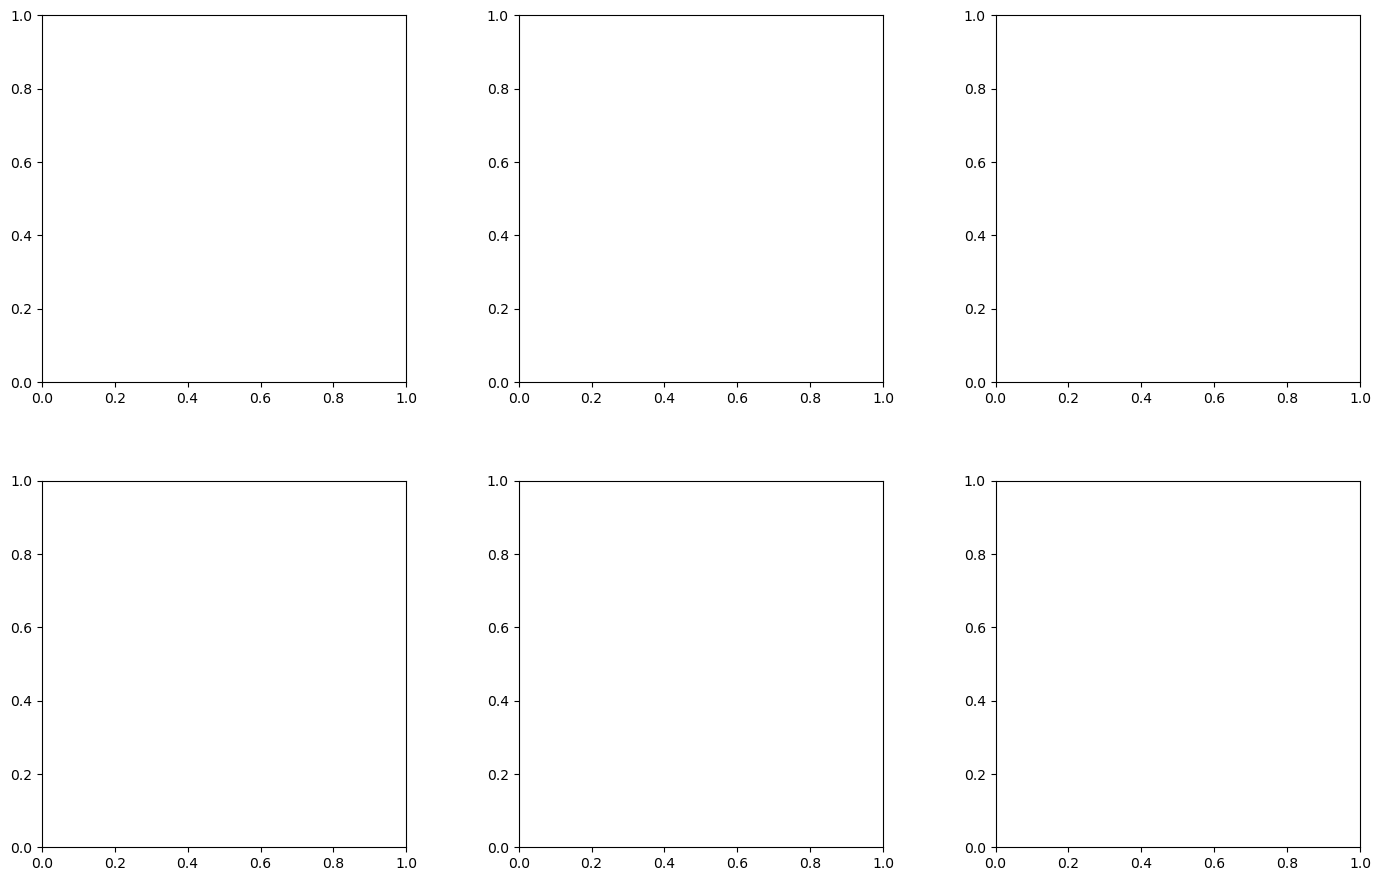

In [16]:
import warnings
import pandas as pd
import numpy as np
import os.path as op
import statsmodels.api as sm
from scipy.stats import chi2
from scipy import stats
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# outdir = 'D:\\ERICK\\MD\\predictions (ORIGINAL)\\'
files = ["visual", "auditory", "somatosensory"]
columns = ['Região', 'Viés de duração', '95% IC', 'chi-quadrado', 'valor-p']
df = pd.DataFrame(columns=columns)
overwrite = False
n = 38

# Criar figuras com subplots (2 linhas e 3 colunas)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.tight_layout(pad=5.0)
# fig.suptitle('Comparação de Viés Humano e Modelo por Região', fontsize=16)

for i, region in enumerate(files): 
    print('--------------------------------')
    print(region)
    model_file = op.join(outdir, 'predicted_{}.csv'.format(region))
    model_data = pd.read_csv(model_file)

    # Regressão => bias (human) = B0 + B1 * bias (model)
    x = model_data['modelBias']
    y = model_data['humanBias']
    
    # Correlação
    rho, p = stats.spearmanr(x, y)
    R2 = 1 - np.sum(np.square(y - x)) / np.sum(np.square(y - np.mean(y)))
    print('Correlation between human and model bias: r = {:.2f}, p = {:.3f}'.format(rho, p))
    print('R2 = {:.2f}'.format(R2))
    
    modelo = sm.OLS(y, sm.add_constant(x)).fit()
    print('Linear Regression between human and model bias: beta = {:.2f} ± {:.2f}, p = {:.3f}'.format(modelo.params[1], modelo.bse[1], modelo.f_pvalue))

    # PLOT COM QUANTIS
    bias_plot = pd.DataFrame({'hb_norm': y, 'mb_norm': x})
    bias_plot['quantil'] = pd.qcut(bias_plot['hb_norm'], 25, labels=False)
    
    # Média e desvio padrão de mb_norm para cada quantil
    means_hb = bias_plot.groupby('quantil')['hb_norm'].mean()
    means_mb = bias_plot.groupby('quantil')['mb_norm'].mean()
    quantil_sem = bias_plot.groupby('quantil')['mb_norm'].sem()
    quantiles = np.arange(0, 25)
    
    # Subplot na primeira linha (com quantis)
    axs[0, i].errorbar(quantiles, means_mb, yerr=quantil_sem, fmt='o', capsize=5)
    axs[0, i].set_xlabel('Human bias (quantiles)', fontsize=13)
    axs[0, i].set_ylabel('Mean model bias', fontsize=13)
    axs[0, i].set_title(f'{region} model', fontsize=20)
    axs[0, i].plot(np.arange(-1, 26), np.arange(-1, 26)*0, color='black')
    axs[0, i].set_xlim([-0.5, 25.1])
    
    # PLOT SEM QUANTIS
    hb_norm = (y - np.mean(y)) / np.std(y)
    mb_norm = (x - np.mean(x)) / np.std(x)
    ident = np.arange(min(y), max(y))
    b, a = modelo.params
    linReg = b + a * ident

    # Subplot na segunda linha (sem quantis)
    axs[1, i].plot(ident, ident, color='black', linestyle='--')
    axs[1, i].plot(ident, linReg, color='red')
    axs[1, i].scatter(x, y)
    axs[1, i].set_ylabel('Human bias', fontsize=13)
    axs[1, i].set_xlabel('Model bias', fontsize=13)
#     axs[1, i].set_title(f'{region} model', fontsize=14)
    axs[1, i].set_ylim([min(y) - 10, 140])
    axs[1, i].set_xlim([min(x) - 10, max(x) + 10])

    if region == 'visual':
        axs[1, i].annotate(f'$r$ = {rho:.2f}', xy=(0.03, 0.94), xycoords='axes fraction', fontsize=12, color='black')
        axs[1, i].annotate(f'$\\beta$ = {a:.2f}', xy=(0.03, 0.89), xycoords='axes fraction', fontsize=12, color='black')

# Exibir o gráfico com subplots
plt.show()

if overwrite:
    outFile = op.join(outdir, 'lmm_table_rep.csv')
    df.to_csv(outFile, sep=',', encoding='utf-8')

In [178]:
df

,hb_norm,mb_norm,quantil
0,3.123058,-0.201203,24
1,1.230021,0.379857,23
2,1.952422,-1.213803,24
3,2.332698,2.022160,24
4,-1.448530,2.217093,0
...,...,...,...
2206,-1.167720,1.965514,1
2207,0.485105,0.100577,19
2208,0.516319,0.321752,19
2209,0.246395,-1.558069,16


In [148]:
# análise de viés do modelo para cada camada
import warnings
warnings.filterwarnings("ignore")

# outdir = 'D:\\ERICK\\MD\\predictions (ORIGINAL)\\'
files = ["visual","auditory","somatosensory"]
layers = ['l1', 'l2', 'l3']
columns = ['Região', 'Camada', 'Viés de duração', '95% IC', 'chi-quadrado', 'valor-p']
df = pd.DataFrame(columns=columns)

for region in files:
    print('---------------------------------------')
    print(region)
    for layer, l in enumerate(layers):
        print(l)
        model_file = op.join(outdir, 'predicted_{}_{}.csv'.format(region, l))
        model_data = pd.read_csv(model_file)
    #     #plot model bias hist
    #     plt.hist(model_data['modelBias'])
    #     plt.show()

        orig_file = op.join(datadir, 'master_dataset.csv')
        orig = pd.read_csv(orig_file)
        model_data['humanBias'] = orig['humanBias']

        #EFEITO FIXO = MODEL BIAS
        vc = {'subj': '1 + C(subj)'}
        # Ajustar o modelo reduzido sem o efeito fixo
        model_reduced = sm.MixedLM.from_formula("humanBias ~ 1", vc_formula=vc, data=model_data, groups=model_data['subj'])
        result_reduced = model_reduced.fit()
        # Ajustar o modelo completo com o efeito fixo
        model_full = sm.MixedLM.from_formula("humanBias ~ 1 + modelBias", vc_formula=vc, data=model_data, groups=model_data['subj'])
        result_full = model_full.fit()
        # Calcular a diferença nas log-verossimilhanças
        llf_full = result_full.llf
        llf_reduced = result_reduced.llf
        lrt = -2 * (llf_reduced - llf_full)
        # Calcular o valor p do teste
        p_value = chi2.sf(lrt, 1)
        #calculate and print statistics
        mean = np.mean(avgmb_all[f'{region}_{l}'])
        SE = np.std(avgmb_all[f'{region}_{l}'], ddof=1)/np.sqrt(n)    
        z = 1.96  # Valor crítico para um intervalo de confiança de 95%
        lower_bound = mean - (z * SE)
        upper_bound = mean + (z * SE)
        print('Using model bias as fixed effect: M±SEdiff = {:.2f} ± {:.2f} (normalized bias, %), 95% CI [{:.2f}, {:.2f}], chi-sqr = {:.2f}, p = {:.3f}'
              .format(mean, SE, lower_bound, upper_bound, lrt, p_value))

        #EFEITO FIXO = CENA
        vc = {'subj': '1 + C(subj)'}
        # Ajustar o modelo reduzido sem o efeito fixo
        model_reduced = sm.MixedLM.from_formula("modelBias ~ 1", vc_formula=vc, data=model_data, groups=model_data['subj'])
        result_reduced = model_reduced.fit()
        # Ajustar o modelo completo com o efeito fixo
        model_full = sm.MixedLM.from_formula("modelBias ~ 1 + isCity", vc_formula=vc, data=model_data, groups=model_data['subj'])
        result_full = model_full.fit()
        # Calcular a diferença nas log-verossimilhanças
        llf_full = result_full.llf
        llf_reduced = result_reduced.llf
        lrt = np.round(-2 * (llf_reduced - llf_full), 2)
        # Calcular o valor p do teste
        p_value = np.round(chi2.sf(lrt, 1), 3)
        #calculate and print statistics
        mean = np.round(np.mean(avgmb_diff[f'{region}_{l}']), 2)
        SE = np.round(np.std(avgmb_diff[f'{region}_{l}'], ddof=1)/np.sqrt(n), 2)
        z = 1.96  # Valor crítico para um intervalo de confiança de 95%
        lower_bound = np.round(mean - (z * SE), 2)
        upper_bound = np.round(mean + (z * SE), 2)
        print('Using scene as fixed effect: M±SEdiff = {:.2f} ± {:.2f} (normalized bias, %), 95% CI [{:.2f}, {:.2f}], chi-sqr = {:.2f}, p = {:.3f}'
              .format(mean, SE, lower_bound, upper_bound, lrt, p_value))

        linha = [region, l, '{} ± {}'.format(mean, SE), [lower_bound, upper_bound], lrt, p_value]
        df.loc[len(df)] = linha
    
outFile = op.join(outdir, 'lmm_table_rep_layers.csv')
df.to_csv(outFile, sep=',', encoding='utf-8')

---------------------------------------
visual
l1
Using model bias as fixed effect: M±SEdiff = 0.07 ± 1.79 (normalized bias, %), 95% CI [-3.43, 3.57], chi-sqr = 1.90, p = 0.168
Using scene as fixed effect: M±SEdiff = 0.07 ± 1.79 (normalized bias, %), 95% CI [-3.44, 3.58], chi-sqr = 81.01, p = 0.000
l2
Using model bias as fixed effect: M±SEdiff = 0.05 ± 2.15 (normalized bias, %), 95% CI [-4.17, 4.27], chi-sqr = -3.40, p = 1.000
Using scene as fixed effect: M±SEdiff = 0.05 ± 2.15 (normalized bias, %), 95% CI [-4.16, 4.26], chi-sqr = 29.38, p = 0.000
l3
Using model bias as fixed effect: M±SEdiff = 0.05 ± 2.21 (normalized bias, %), 95% CI [-4.28, 4.38], chi-sqr = -3.99, p = 1.000
Using scene as fixed effect: M±SEdiff = 0.05 ± 2.21 (normalized bias, %), 95% CI [-4.28, 4.38], chi-sqr = 31.13, p = 0.000
---------------------------------------
auditory
l1
Using model bias as fixed effect: M±SEdiff = 0.01 ± 1.58 (normalized bias, %), 95% CI [-3.10, 3.11], chi-sqr = -1.91, p = 1.000
Using scene 

visual


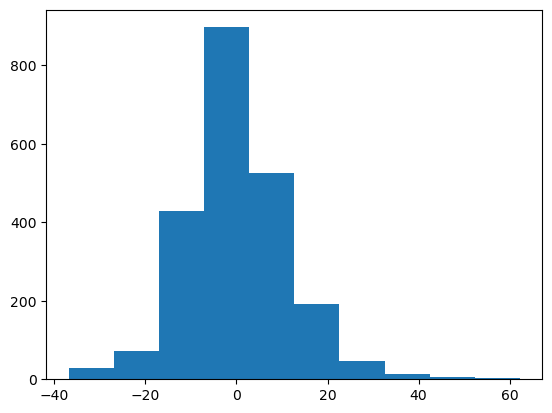

Using model bias as fixed effect: Beta = 0.1372242396887179, chi-sqr = 1.74, p = 0.187
Using scene as fixed effect: M±SEdiff = 4.13 ± 0.55 (normalized bias, %), 95% CI [3.05, 5.21], chi-sqr = 77.30, p = 0.000
auditory


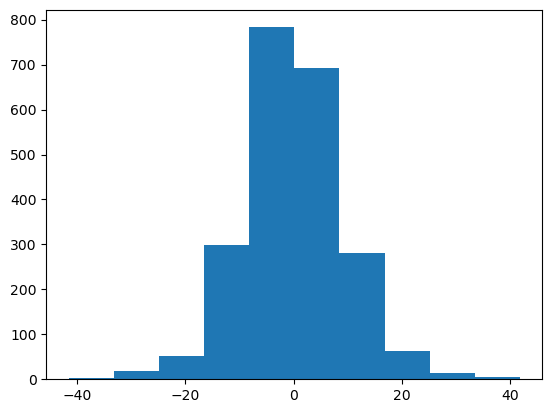

Using model bias as fixed effect: Beta = -0.06862543794057836, chi-sqr = -2.52, p = 1.000
Using scene as fixed effect: M±SEdiff = 0.16 ± 0.43 (normalized bias, %), 95% CI [-0.68, 1.00], chi-sqr = -0.01, p = 1.000
somatosensory


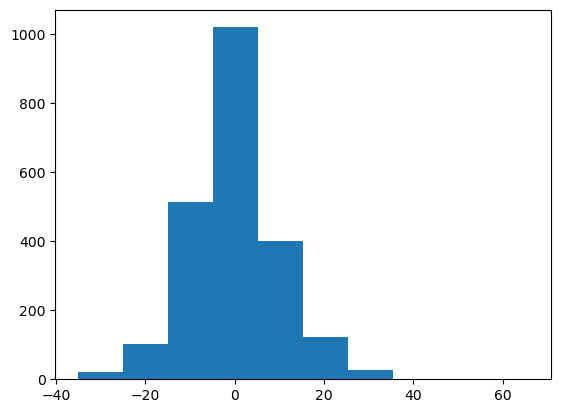

Using model bias as fixed effect: Beta = 0.058930863737562435, chi-sqr = -2.80, p = 1.000
Using scene as fixed effect: M±SEdiff = -0.43 ± 0.42 (normalized bias, %), 95% CI [-1.25, 0.39], chi-sqr = 1.00, p = 0.317


In [29]:
import warnings
warnings.filterwarnings("ignore")

# outdir = 'D:\\ERICK\\MD\\predictions (ORIGINAL)\\'
outdir = 'D:\\ERICK\\MD\\prediction_data\\'
files = ["visual","auditory","somatosensory"]
columns = ['Região', 'Viés de duração', '95% IC', 'chi-quadrado', 'valor-p']
df = pd.DataFrame(columns=columns)

for region in files: 
    print(region)
    model_file = op.join(outdir, 'predicted_{}.csv'.format(region))
    model_data = pd.read_csv(model_file)
    #plot model bias hist
    plt.hist(model_data['modelBias'])
    plt.show()
    
    orig_file = op.join(datadir, 'master_dataset.csv')
    orig = pd.read_csv(orig_file)
    model_data['humanBias'] = orig['humanBias']
    
    #EFEITO FIXO = MODEL BIAS
    vc = {'subj': '1 + C(subj)'}
    # Ajustar o modelo reduzido sem o efeito fixo
    model_reduced = sm.MixedLM.from_formula("humanBias ~ 1", vc_formula=vc, data=model_data, groups=model_data['subj'])
    result_reduced = model_reduced.fit()
    # Ajustar o modelo completo com o efeito fixo
    model_full = sm.MixedLM.from_formula("humanBias ~ 1 + modelBias", vc_formula=vc, data=model_data, groups=model_data['subj'])
    result_full = model_full.fit()
    # Calcular a diferença nas log-verossimilhanças
    llf_full = result_full.llf
    llf_reduced = result_reduced.llf
    lrt = -2 * (llf_reduced - llf_full)
    # Calcular o valor p do teste
    p_value = chi2.sf(lrt, 1)
    #calculate and print statistics
    mean = np.mean(avgmb_all[region])
    SE = np.std(avgmb_all[region], ddof=1)/np.sqrt(n)    
    z = 1.96  # Valor crítico para um intervalo de confiança de 95%
    lower_bound = mean - (z * SE)
    upper_bound = mean + (z * SE)
    print('Using model bias as fixed effect: Beta = {}, chi-sqr = {:.2f}, p = {:.3f}'
          .format(result_full.params[1], lrt, p_value))
    
    #EFEITO FIXO = CENA
    vc = {'subj': '1 + C(subj)'}
    # Ajustar o modelo reduzido sem o efeito fixo
    model_reduced = sm.MixedLM.from_formula("modelBias ~ 1", vc_formula=vc, data=model_data, groups=model_data['subj'])
    result_reduced = model_reduced.fit()
    # Ajustar o modelo completo com o efeito fixo
    model_full = sm.MixedLM.from_formula("modelBias ~ 1 + isCity", vc_formula=vc, data=model_data, groups=model_data['subj'])
    result_full = model_full.fit()
    # Calcular a diferença nas log-verossimilhanças
    llf_full = result_full.llf
    llf_reduced = result_reduced.llf
    lrt = np.round(-2 * (llf_reduced - llf_full), 2)
    # Calcular o valor p do teste
    p_value = np.round(chi2.sf(lrt, 1), 3)
    #calculate and print statistics
    mean = np.round(np.mean(avgmb_diff[region]), 2)
    SE = np.round(np.std(avgmb_diff[region], ddof=1)/np.sqrt(n), 2)
    z = 1.96  # Valor crítico para um intervalo de confiança de 95%
    lower_bound = np.round(mean - (z * SE), 2)
    upper_bound = np.round(mean + (z * SE), 2)
    print('Using scene as fixed effect: M±SEdiff = {:.2f} ± {:.2f} (normalized bias, %), 95% CI [{:.2f}, {:.2f}], chi-sqr = {:.2f}, p = {:.3f}'
          .format(mean, SE, lower_bound, upper_bound, lrt, p_value))
    
    linha = [region, '{} ± {}'.format(mean, SE), [lower_bound, upper_bound], lrt, p_value]
    df.loc[len(df)] = linha
    
# outFile = op.join(outdir, 'lmm_table_original.csv')
# df.to_csv(outFile, sep=',', encoding='utf-8')

In [27]:
model_file

'D:\\ERICK\\MD\\predictions (ORIGINAL)\\predicted_visual.csv'

# FIG 6

Average model bias for city is 2.06 and for office is -2.07
Average model bias for city is 0.08 and for office is -0.08
Average model bias for city is -0.22 and for office is 0.21


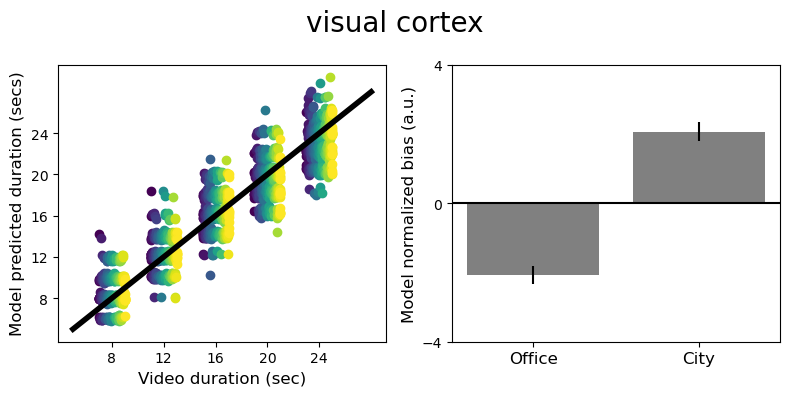

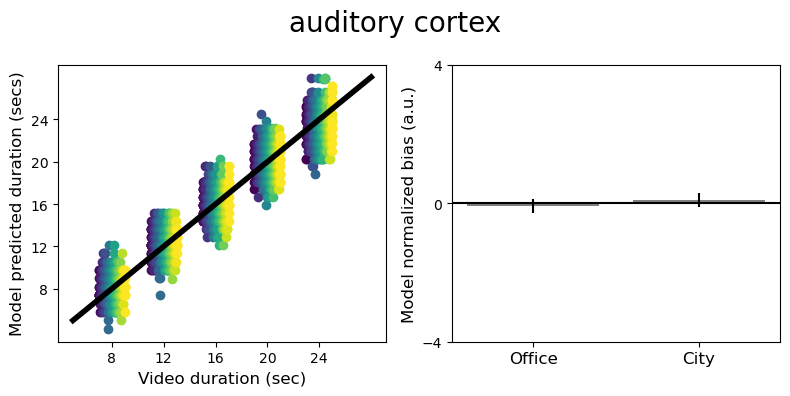

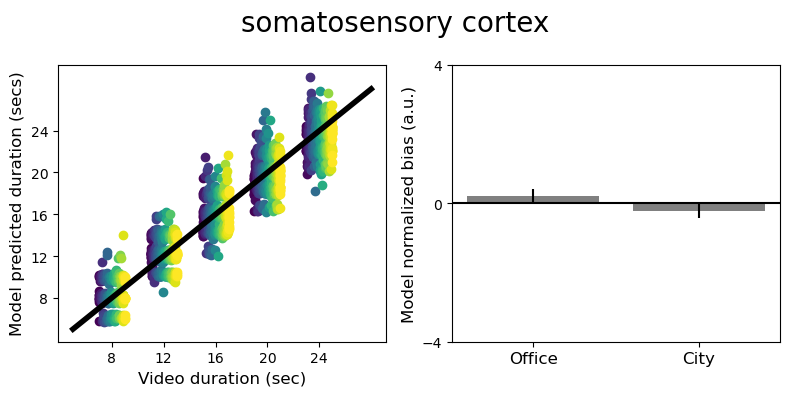

In [265]:
#plotting FIG6
files = ["visual","auditory","somatosensory"]
durations = [8, 12, 16, 20, 24]
excluded = [41, 45]
x = np.linspace(5, 28, 5)
y = x  # Função x=y

i = 0
for region in files:
    print(f'Average model bias for city is {np.mean(avgmb_c[region]):.2f} and for office is {np.mean(avgmb_o[region]):.2f}')
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    load_file = op.join(outdir, 'predicted_{}.csv'.format(region))
    data = pd.read_csv(load_file)
    chart1 = axs[0]
    subj_list = data['subj'].unique()
    pos = np.linspace(-1, 1, len(subj_list))

    for subj in range(1, len(subj_list)+1):
#         if subj+5 in excluded:
#             print('skipping subj')
#             continue
#         print(subj)
        subset = data.loc[(data['subj'] == subj)]
        cor = plt.cm.viridis((subj - 1) / (len(subj_list) - 1))
        durs = subset['duration']+pos[subj-1]
        chart1.scatter(durs, subset['predicted'], color=cor)
    chart1.set_xlabel('Video duration (sec)', fontsize=12)
    chart1.set_ylabel('Model predicted duration (secs)', fontsize=12) 
    chart1.set_xticks(durations)
    chart1.set_yticks(durations)
    #unity
    chart1.plot(x, y, color='black', linewidth=4)

    chart2 = axs[1]
    sem_c = np.std(avgmb_c[region]) / np.sqrt(40)
    sem_o = np.std(avgmb_o[region]) / np.sqrt(40)
    x_pos = np.arange(2)
    heights = [np.mean(avgmb_o[region]), np.mean(avgmb_c[region])]
    errors = [sem_o, sem_c] 
    chart2.bar(x_pos, heights, yerr=errors, color='grey')
    chart2.set_ylabel('Model normalized bias (a.u.)', fontsize=12) 
    chart2.set_xticks(x_pos)
    chart2.set_yticks([-4, 0, 4])
    chart2.set_xticklabels(['Office', 'City'], fontsize=12)
    chart2.axhline(0, color='black')
    
    fig.suptitle(f'{region} cortex', fontsize=20) 
    plt.tight_layout()
    
plt.show()

In [262]:
data

,Unnamed: 0.1,Unnamed: 0,subj,duration,isCity,report,humanBias,estimationError,predicted,l1,l2,l3,modelBias
0,0,0,1.0,24.0,0.0,29.5,97.654941,5.5,22.576390,10.0,9.0,2.0,-2.008957
1,1,1,1.0,16.0,1.0,14.7,38.461538,1.3,15.838835,7.0,4.0,0.0,3.792772
2,2,2,1.0,20.0,0.0,18.4,61.050328,1.6,16.355248,7.0,6.0,2.0,-12.119513
3,3,3,1.0,8.0,1.0,9.8,72.941176,1.8,10.040526,4.0,3.0,1.0,20.190752
4,4,4,1.0,8.0,0.0,3.1,-45.294118,4.9,10.203122,4.0,4.0,3.0,22.137111
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,2206,2206,38.0,8.0,0.0,6.1,-36.513443,1.9,9.691207,4.0,2.0,1.0,19.625162
2207,2207,2207,38.0,24.0,0.0,23.6,15.168768,0.4,23.829412,11.0,8.0,2.0,1.004233
2208,2208,2208,38.0,24.0,1.0,23.8,16.144774,0.2,24.350424,11.0,9.0,1.0,3.212616
2209,2209,2209,38.0,12.0,1.0,11.3,7.704527,0.7,10.131566,4.0,3.0,0.0,-15.556920


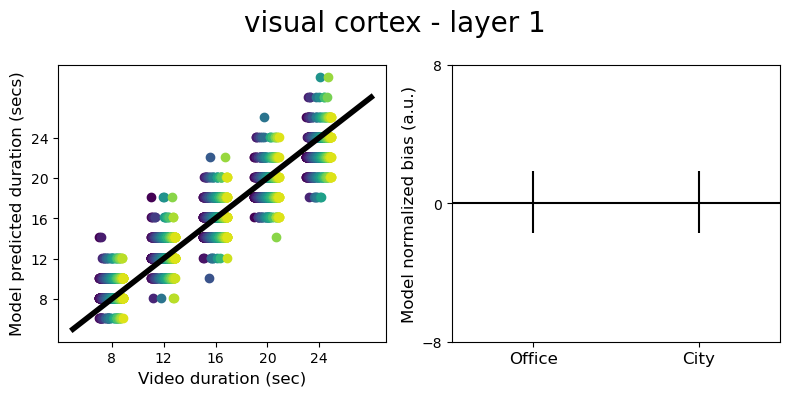

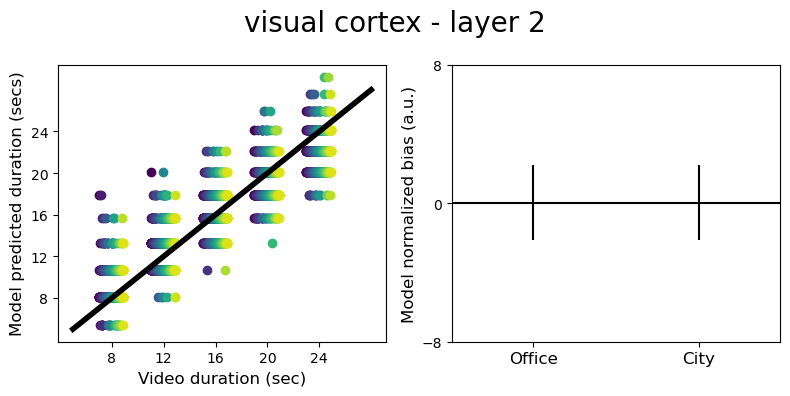

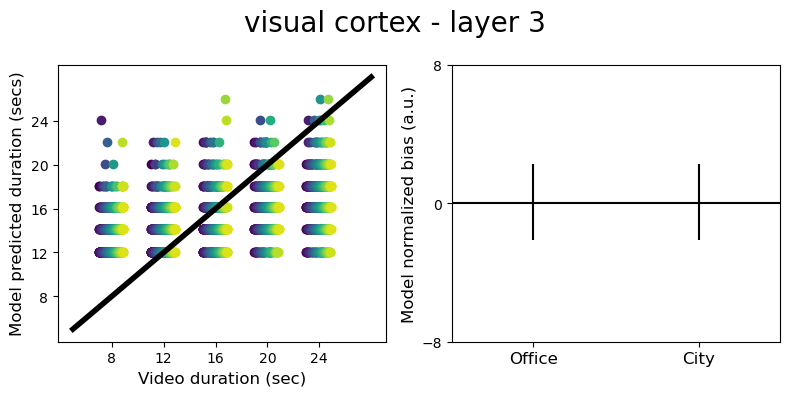

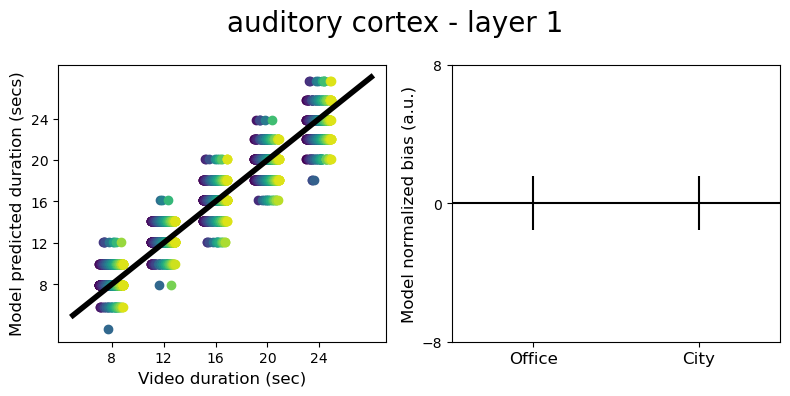

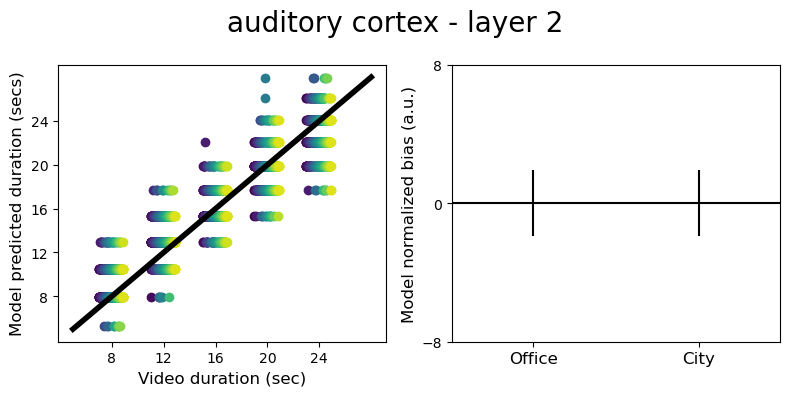

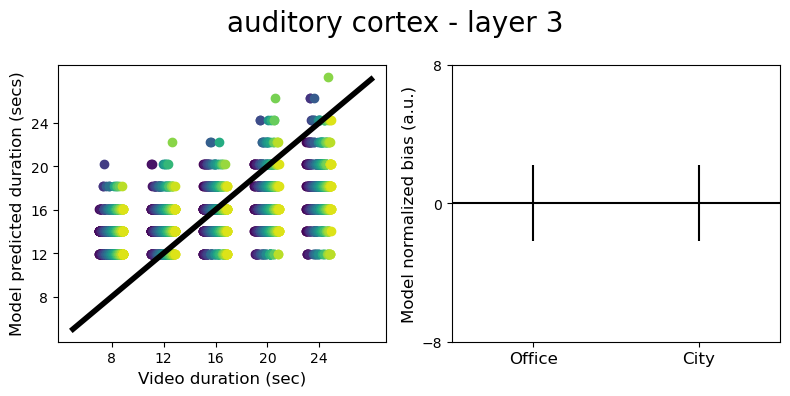

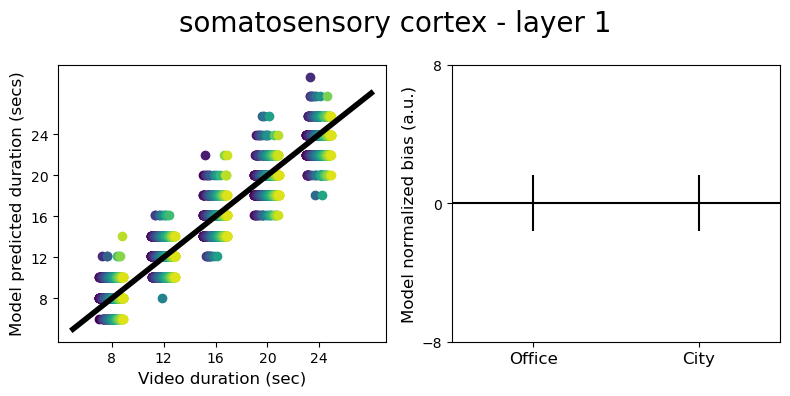

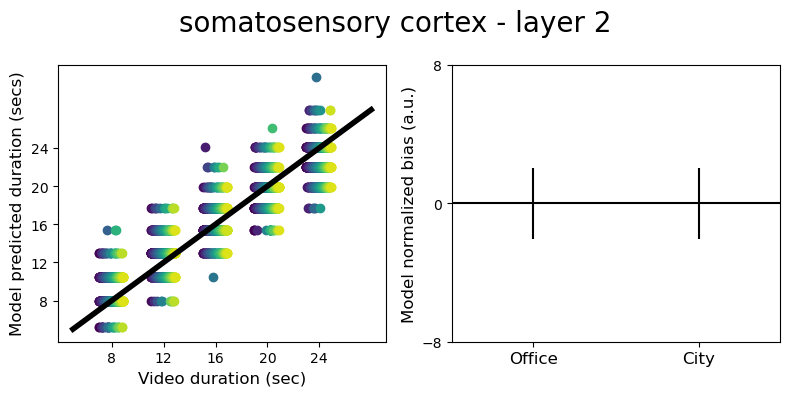

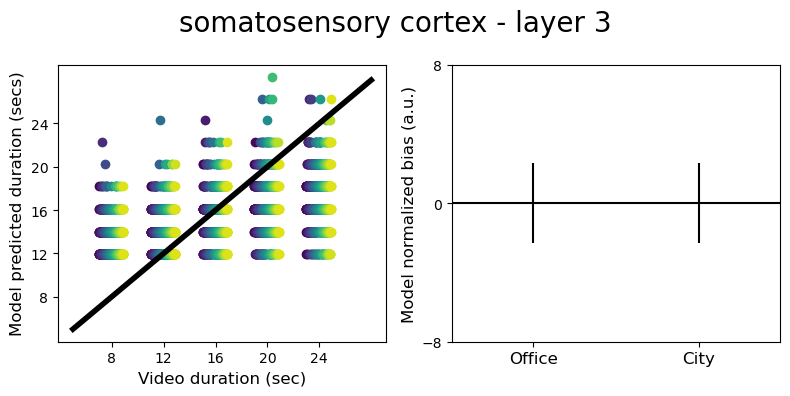

In [149]:
# PARA CADA CAMADA SEPARADAMENTE
#plotting FIG6
files = ["visual","auditory","somatosensory"]
layers = ['l1', 'l2', 'l3']
durations = [8, 12, 16, 20, 24]
# excluded = [10, 12, 41, 45]
x = np.linspace(5, 28, 5)
y = x  # Função x=y

i = 0
for region in files:
    for layer, l in enumerate(layers):
#         print(f'Average model bias for city is {np.mean(avgmb_c[region]):.2f} and for office is {np.mean(avgmb_o[region]):.2f}')
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        load_file = op.join(outdir, 'predicted_{}_{}.csv'.format(region, l))
        data = pd.read_csv(load_file)
        chart1 = axs[0]
        pos = np.linspace(-1, 1, 40)
        for subj in range(1, 41):
    #         if subj+5 in excluded:
    #             print('skipping subj')
    #             continue
    #         print(subj)
            subset = data.loc[(data['subj'] == subj)]
            cor = plt.cm.viridis((subj - 1) / (40 - 1))
            durs = subset['duration']+pos[subj-1]
            chart1.scatter(durs, subset['predicted'], color=cor)
        chart1.set_xlabel('Video duration (sec)', fontsize=12)
        chart1.set_ylabel('Model predicted duration (secs)', fontsize=12) 
        chart1.set_xticks(durations)
        chart1.set_yticks(durations)
        #unity
        chart1.plot(x, y, color='black', linewidth=4)

        chart2 = axs[1]
        sem_c = np.std(avgmb_c[f'{region}_{l}']) / np.sqrt(40)
        sem_o = np.std(avgmb_o[f'{region}_{l}']) / np.sqrt(40)
        x_pos = np.arange(2)
        heights = [np.mean(avgmb_o[f'{region}_{l}']), np.mean(avgmb_c[f'{region}_{l}'])]
        errors = [sem_o, sem_c] 
        chart2.bar(x_pos, heights, yerr=errors, color='grey')
        chart2.set_ylabel('Model normalized bias (a.u.)', fontsize=12) 
        chart2.set_xticks(x_pos)
        chart2.set_yticks([-8, 0, 8])
        chart2.set_xticklabels(['Office', 'City'], fontsize=12)
        chart2.axhline(0, color='black')

        fig.suptitle(f'{region} cortex - layer {layer+1}', fontsize=20) 
        plt.tight_layout()

plt.show()

In [18]:
outdir

'D:\\ERICK\\MD\\predictions (ORIGINAL)\\'